<a href="https://colab.research.google.com/github/HanNayeoniee/NLP-study/blob/main/Week_02_LSTM_samsung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LSTM을 활용해 삼성전자 주가 예측하기
- 참고 : 
https://teddylee777.github.io/tensorflow/LSTM%EC%9C%BC%EB%A1%9C-%EC%98%88%EC%B8%A1%ED%95%B4%EB%B3%B4%EB%8A%94-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80
- 데이터셋 : https://drive.google.com/file/d/10hjZ9VRyoaLNNdguedxSfYz0fSqLaWJM/view

In [ ]:
# 데이터가 들어있는 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터셋 생성
# 일자, 시가, 고가, 저가로 종가를 예측하기

data_path = "/content/drive/MyDrive/NLPstudy/data/01-삼성전자-주가.csv"
df = pd.read_csv(data_path, encoding='utf8')
df.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [ ]:
# 날짜 datetime 형식으로 변환

pd.to_datetime(df['일자'], format='%Y%m%d')

df['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df['연도'] = df['일자'].dt.year
df['월'] = df['일자'].dt.month
df['일'] = df['일자'].dt.day

In [ ]:
df

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
...,...,...,...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836,1985,1,9
9284,1985-01-08,129,129,127,127,845098,1985,1,8
9285,1985-01-07,129,130,128,129,771895,1985,1,7
9286,1985-01-05,129,129,128,128,108496,1985,1,5


/bin/bash: -c: line 0: syntax error near unexpected token `../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf'
/bin/bash: -c: line 0: `[stock-data-01](../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf = df.loc[df['연도']>=1990]'


Text(0, 0.5, 'price')

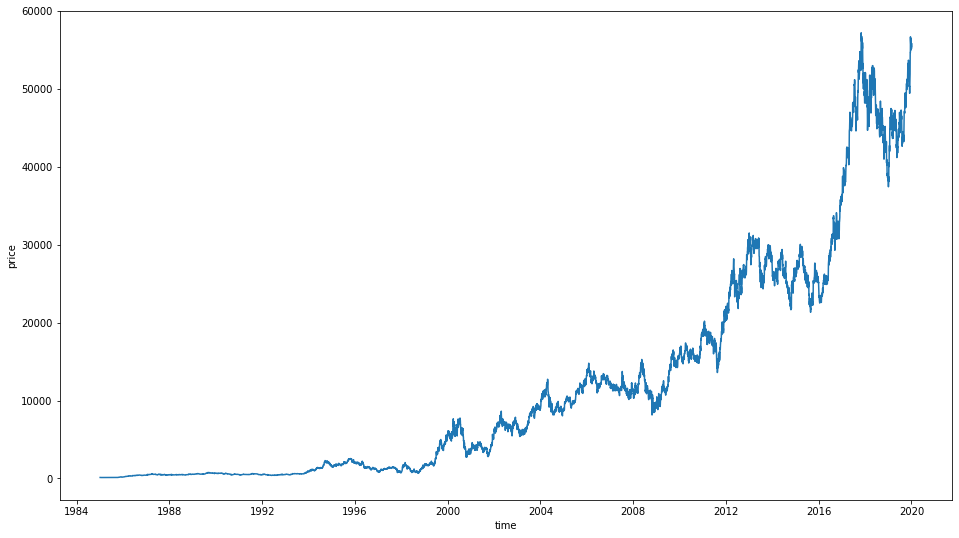

In [ ]:
# 1990년도 이후의 주가 시각화

![stock-data-01](../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf = df.loc[df['연도']>=1990]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
# Normalization
# 전체 학습 데이터를 정규화, 전체 데이터는 0~1사이의 값을 가지게 됨

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,시가,고가,저가,종가,거래량
0,0.968632,0.980489,0.979522,0.975133,0.030291
1,0.954691,0.966553,0.961868,0.969880,0.031470
2,0.973860,0.983973,0.967164,0.969880,0.047217
3,0.965147,0.973521,0.968929,0.964626,0.039781
4,0.977346,0.983973,0.981287,0.975133,0.025585
...,...,...,...,...,...
9283,0.000174,0.000174,0.000124,0.000123,0.000995
9284,0.000227,0.000226,0.000212,0.000193,0.002587
9285,0.000227,0.000244,0.000229,0.000228,0.002363
9286,0.000227,0.000226,0.000229,0.000210,0.000332


In [ ]:
# 학습시킬 데이터셋 생성

TEST_SIZE = 200  # 과거부터 200일 이전의 데이터를 학습함
train = df_scaled[:-TEST_SIZE]  # 처음~200일 이전의 데이터
test = df_scaled[-TEST_SIZE:]  # 200일 이전~현재 데이터


# window_size=20, 과거 20일을 기반으로 내일의 데이터를 예측 
# 데이터셋을 만들어주는 함수
# 순차적으로 20일간의 데이터셋을 묶고, label(예측 데이터)와 함께 return함
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
# feature, label 정의

feature_cols = ['시가', '고가', '저가', '거래량']  # 예측에 사용하려는 columns
label_cols = ['종가']  # 예측할 column

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
# train dataset을 생성한 후 train, validation으로 쪼갠다
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
print(x_train.shape, x_valid.shape)
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)
# ((180, 20, 4), (180, 1))

(7254, 20, 4) (1814, 20, 4)
(180, 20, 4) (180, 1)


In [ ]:
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 ,20]
train = num[:-5]
# test = num[-10:]
train
# test

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
# keras를 활용한 LSTM 모델 생성

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [50]:
# 모델 학습

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = '/content/drive/MyDrive/NLPstudy/res/tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
454/454 [==============================] - 5s 9ms/step - loss: 0.0053 - val_loss: 5.7107e-05

Epoch 00001: val_loss improved from inf to 0.00006, saving model to /content/drive/MyDrive/NLPstudy/res/tmp_checkpoint.h5
Epoch 2/200
454/454 [==============================] - 4s 9ms/step - loss: 5.9813e-05 - val_loss: 5.1112e-05

Epoch 00002: val_loss improved from 0.00006 to 0.00005, saving model to /content/drive/MyDrive/NLPstudy/res/tmp_checkpoint.h5
Epoch 3/200
454/454 [==============================] - 4s 9ms/step - loss: 5.0889e-05 - val_loss: 5.4776e-05

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/200
454/454 [==============================] - 4s 9ms/step - loss: 4.5847e-05 - val_loss: 8.2783e-05

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/200
454/454 [==============================] - 4s 8ms/step - loss: 4.4793e-05 - val_loss: 3.9005e-05

Epoch 00005: val_loss improved from 0.00005 to 0.00004, saving model to /content/drive/MyDrive/NLPstudy/

In [51]:
# weight 로드
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

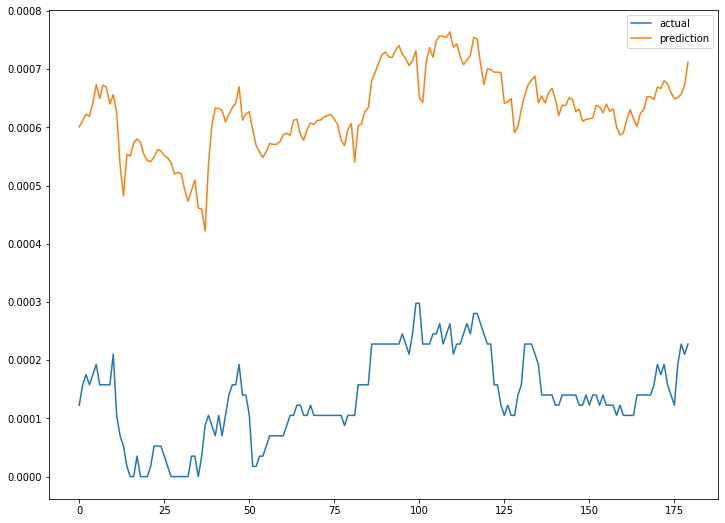

In [55]:
# 실제 데이터와 예측한 데이터 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()